<a href="https://colab.research.google.com/github/RegmiYogesh/NASA_Glacial_vanguard/blob/main/NASA_spaceapp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image
import random
%matplotlib inline
import glob
from osgeo import gdal
from tensorflow import keras
from osgeo import osr
import pandas as pd

In [3]:
from PIL import Image
from tensorflow.python.keras import Model
from tensorflow.python.keras.layers import Conv2D, Input, MaxPooling2D, Conv2DTranspose, Concatenate, Dropout

In [4]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.metrics import Recall, Precision

In [5]:
train_image_dir = sorted(glob.glob("/content/drive/MyDrive/DATA/Image/*.tif"))
train_mask_dir = sorted(glob.glob("/content/drive/MyDrive/DATA/Label/*.tif"))
test_image_dir = sorted(glob.glob("/content/drive/MyDrive/DATA/Image/*.tif"))
test_mask_dir = sorted(glob.glob("/content/drive/MyDrive/DATA/Label/*.tif"))
# pred_image_dir = sorted(glob.glob("B:/datasets/predict_crosswalk/images/*.tif"))
# print(len(train_image_dir),len(test_image_dir),len(pred_image_dir))

In [6]:
len(train_image_dir)

33

**Converting the training files into numpy array**

In [7]:
#converting the training images in numpy array
train_xx = np.zeros((33,512,512,3))
train_yy = np.zeros((33,512,512))

for i, (img, mask) in enumerate(zip(train_image_dir,train_mask_dir)):
    img = gdal.Open(img).ReadAsArray().transpose()
    np_img=cv2.resize(img,(512,512))
    train_xx[i] = np_img

    mask = gdal.Open(mask).ReadAsArray().transpose()
    np_mask=cv2.resize(mask,(512,512))
    train_yy[i] = np_mask

**Converting the test files into numpy array**

In [8]:
#converting the test images in numpy array
test_xx = np.zeros((33,512,512,3))
test_yy = np.zeros((33,512,512))

for i, (img, mask) in enumerate(zip(test_image_dir,test_mask_dir)):
    img = gdal.Open(img).ReadAsArray().transpose()
    np_img=cv2.resize(img,(512,512))
    test_xx[i] = np_img

    mask = gdal.Open(mask).ReadAsArray().transpose()
    np_mask=cv2.resize(mask,(512,512))
    test_yy[i] = np_mask

In [9]:
num_train = len(train_xx)
print (num_train)

33


In [10]:
#random image number
img_num = random.randint(0, num_train-1)
img_num

31

**Plotting the image and mask**

In [ ]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(train_xx[img_num,:,:,:].astype('uint8'))
plt.title("Image")
plt.subplot(1,2,2)
plt.imshow(train_yy[img_num,:,:].astype('uint8'))
plt.title("Mask")
#plt.show()

**Model Preparation**

In [12]:
img_size = 512

# training attributes
batch_size = 64
epochs = 100


In [13]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

In [14]:


def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)

    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [15]:
input_img = Input((512, 512, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy", Recall(), Precision()])

In [16]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ img (InputLayer)          │ (None, 512, 512, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 512, 512, 16)   │            448 │ img[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 512, 512, 16)   │             64 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 512, 512, 16)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 512, 512, 16)   │          2,320 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 512, 512, 16)   │             64 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 512, 512, 16)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 256, 256, 16)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 256, 16)   │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 32)   │          4,640 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 256, 256, 32)   │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 256, 256, 32)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 32)   │          9,248 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 256, 256, 32)   │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 256, 256, 32)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 128, 128, 32)   │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)  

 Total params: 2,164,593 (8.26 MB)

 Trainable params: 2,161,649 (8.25 MB)

 Non-trainable params: 2,944 (11.50 KB)

**Training the model**

In [17]:
History = model.fit(train_xx, train_yy, validation_data=(test_xx, test_yy), epochs=20, batch_size=5, verbose=1)
model.save('/content/drive/MyDrive/demo/model_100_epochs.h5')

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 178s 24s/step - accuracy: 0.9408 - loss: nan - precision: 0.0041 - recall: 0.0250 - val_accuracy: 0.9908 - val_loss: nan - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 157s 23s/step - accuracy: 0.9894 - loss: nan - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9908 - val_loss: nan - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 193s 22s/step - accuracy: 0.9914 - loss: nan - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9908 - val_loss: nan - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 201s 22s/step - accuracy: 0.9915 - loss: nan - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9908 - val_loss: nan - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 160s 24s/step - accuracy: 0.9897 - loss: nan - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accu

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(History.history["accuracy"], label="train_accuracy")
plt.plot(History.history["val_accuracy"], label="val_accuracy")
plt.plot( np.argmin(History.history["val_accuracy"]), np.min(History.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();
plt.show()

In [ ]:
import ee
import geopandas as gpd
import requests
import os

In [ ]:
ee.Authenticate()

True

In [ ]:
ee.Initialize(project='yogesh-376506')

In [ ]:
aoi_path =r'/content/drive/MyDrive/Nepal_data.shp/khumbupasanglamu.shp'

In [ ]:
gdf = gpd.read_file(aoi_path)
roi = gdf.__geo_interface__['features'][0]['geometry']
ee_geometry = ee.Geometry(roi)

In [ ]:
 import geemap
 # Function to mask clouds using the QA60 band of Sentinel-2 imagery
def maskS2clouds(image):
    qa = image.select('QA60')

    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11

    # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))

    return image.updateMask(mask).divide(10000)

# Load the Sentinel-2 Image Collection
dataset = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
                  .filterDate('2020-01-01', '2020-12-30') \
                  .map(maskS2clouds)

 # Select only the RGB bands (B4: Red, B3: Green, B2: Blue)
dataset_rgb = dataset.select(['B4', 'B3', 'B2'])

# Visualization parameters
visualization = {
    'min': 0.0,
    'max': 0.3,
    'bands': ['B4', 'B3', 'B2'],
}

# Create a map object using geemap
Map = geemap.Map()
Map.centerObject(ee_geometry,10)
# Add the mean image layer to the map
mean_rgb_image = dataset_rgb.mean().clip(ee_geometry)
Map.addLayer(mean_rgb_image, visualization, 'Sentinel-2 RGB')

# Display the map
Map

Map(center=[27.877185732286385, 86.72924423464679], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:

task = ee.batch.Export.image.toDrive(**{
    'image': mean_rgb_image,
    'description': 'Sentinel2_RGB_Image',
    'folder': 'yogesh',
    'fileNamePrefix': 'Sentinel2_RGB',
    'region': ee_geometry,
    'scale': 10,
    'maxPixels': 1e13
})
task.start()

print('Task ID:', task.id)


Task ID: OZQQIDODAKSKBLZ6DKLFU44W


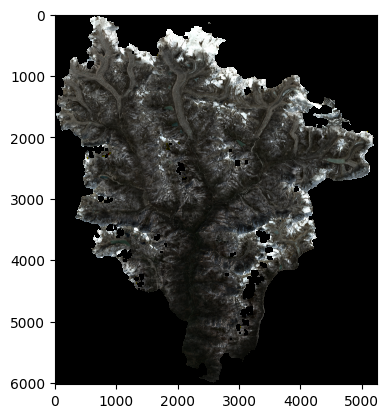

In [ ]:


import pandas as pd
import geopandas as gpd
from osgeo import gdal

# Assuming you have a GeoTIFF file named 'your_geotiff.tif'
geotiff_file = '/content/drive/MyDrive/yogesh/Sentinel2_RGB.tif'
img = gdal.Open(geotiff_file)
transform=img.GetGeoTransform()
projection=img.GetProjection()
spatial_ref = osr.SpatialReference()
spatial_ref.ImportFromWkt(projection)
bands = [img.GetRasterBand(band+1) for band in range(img.RasterCount)]
listOfArrays = [band.ReadAsArray() for band in bands]
image = np.array(listOfArrays)

image.shape
#height,width,band
image=image.transpose(1,2,0)
plt.imshow(image)



In [ ]:
# Slice the image into 512 x 512 patches for prediction.

# Some variables.
patch_size = 512
overlap = 0.5

height, width, bands = image.shape
im_list, name_list, pos_list = [], [], []

pos_columns = ['name', 'xmin', 'ymin', 'patch_size', 'im_x', 'im_y']

seen_coords = set()

# Iterate through image and bin it up appropriately.
for x in range(0, width - 1, int(patch_size * (1 - overlap))):          # In this case, the stride is approx. 205 pixels.
    for y in range(0, height - 1, int(patch_size * (1 - overlap))):     # Same as above.

        xmin = min(x, width - patch_size)
        ymin = min(y, height - patch_size)
        coords = (xmin, ymin)

        # check if we've already seen these coords
        if coords in seen_coords:
            # print ("coords already encountered (xmin, ymin):", coords)
            continue
        else:
            seen_coords.add(coords)

        # check if we screwed up binning
        if (xmin + patch_size > width) or (ymin + patch_size > height):
            print ("Oops. Improperly binned image.")
            continue

        # get image cutout
        im_cutout = image[ymin:ymin + patch_size, xmin:xmin + patch_size]

        # set slice name
        name = 'patch_x' + str(xmin) + '_y' + str(ymin) + '_sz' + str(patch_size) + '_w' + str(width) + '_h' + str(height)

        pos = [name, xmin, ymin, patch_size, width, height]

        # add to arrays
        name_list.append(name)
        im_list.append(im_cutout)
        pos_list.append(pos)

# convert to np arrays
name_out_arr = np.array(name_list)
im_out_arr = np.array(im_list)
pred_array = im_out_arr

# create position datataframe
df_pos = pd.DataFrame(pos_list, columns=pos_columns)
df_pos.index = np.arange(len(df_pos))


In [ ]:
len(pos_list)

460

In [ ]:
#Prediction
threshold = 0.6

# prediction of the output
pred_test = model.predict(pred_array)
predictions = (pred_test > threshold).astype(np.uint8)

15/15 ━━━━━━━━━━━━━━━━━━━━ 419s 27s/step


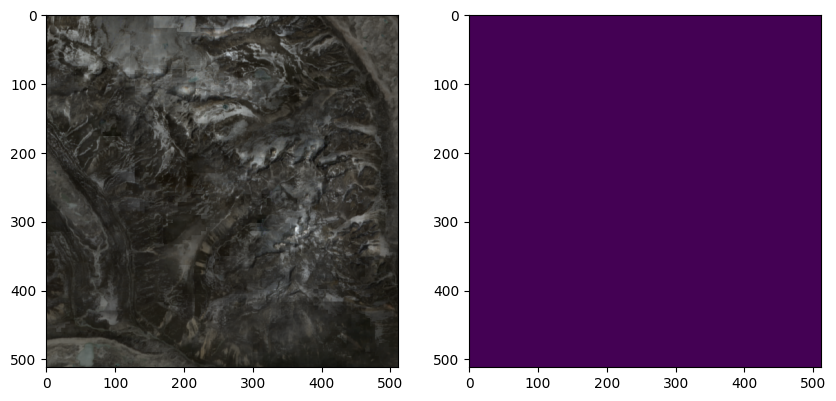

In [ ]:
img_num = 51

orig = tf.squeeze(predictions[img_num])
prediction = pred_array[img_num]
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(prediction)
plt.subplot(1,2,2)
plt.imshow(orig)

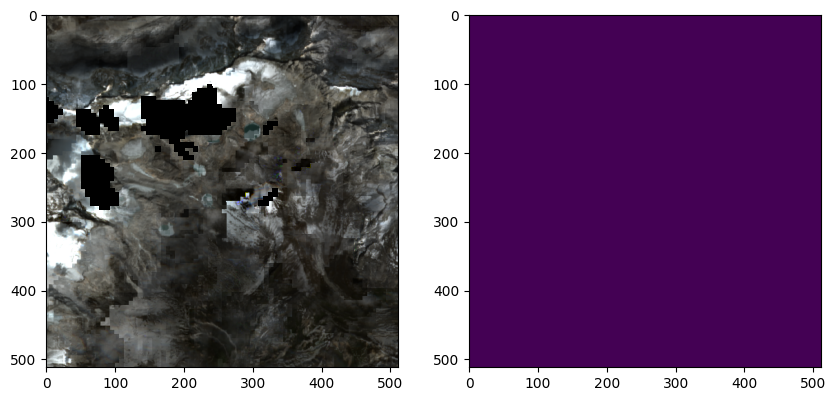

In [ ]:
img_num = 54

orig = tf.squeeze(predictions[img_num])
prediction = pred_array[img_num]
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(prediction)
plt.subplot(1,2,2)
plt.imshow(orig)

In [ ]:
# Rebuild the predictions into a single image.

# For a dataframe of image positions (df_pos), and the tiles of that image
# (im_arr), reconstruct the image.

# Create numpy zeros of appropriate shape.
empty_img = np.zeros((height, width, 1))

# Create another zero array to record where pixels are overlaid.
overlay_count = np.zeros((height, width, 1))

# Iterate through patches.
for index, item in df_pos.iterrows():

    # Grab values for each row / patch.
    [name, xmin, ymin, patch_slice, im_x, im_y] = item

    # Grab the right patch.
    img_slice = predictions[index]

    x0, x1 = xmin, xmin + patch_size
    y0, y1 = ymin, ymin + patch_size

    # Add img_slice to empty_img.
    empty_img[y0:y1, x0:x1] += img_slice

    # Update count of overlapping pixels.
    overlay_count[y0:y1, x0:x1] += np.ones((patch_size, patch_size, 1))

rebuilt_img = np.divide(empty_img, overlay_count)